# SpO2 Signal quality
Measure Spo2 quality by using cross corelation between two consecutive R PPG segment, and correlation between R and IR segment.

## import module and declare function

In [3]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv

# For read maxim excel file
def maxm_reader(folder, subfolder, source):
    file_path = os.path.join(folder, subfolder)
    for f in os.listdir(file_path):
        if re.findall(source, f):
            ext = os.path.splitext(str(f))[-1].lower()
            if ext == '.csv':
                file_name = str(f)
                f_check = True
                break
            else:
                f_check = False

    if f_check:
        full_path = os.path.join(file_path, file_name)
        reader = csv.reader(open(full_path))

        dataDict = []
        for i, row in enumerate(reader):
            if i == 6:
                first_row = row[:-1] #ignore last empty value
                dataDict = {r:[] for r in first_row}
            elif i > 6:
                if row[0] == 'stop time':
                    break
                for col in range(len(first_row)):
                    if row[col] == '':
                        _value = None
                    else:
                        _value = float(row[col])
                    dataDict[first_row[col]].append(_value)
        return dataDict
    else:
        raise Exception('File not found:{}'.format(file_path))

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms



def snr_calc(signal):
    return 20* math.log(np.abs(np.mean(signal)/np.std(signal)),10)



## Main function

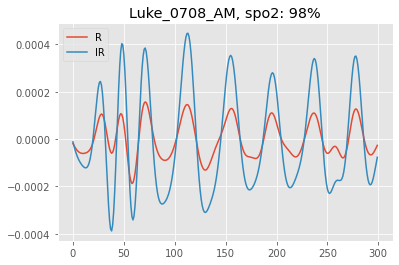

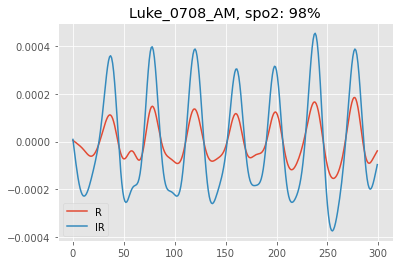

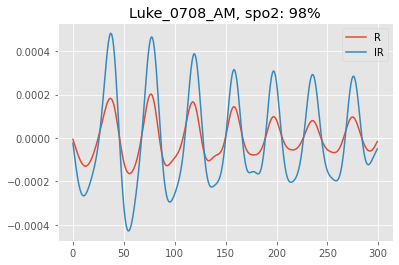

In [4]:

# Select reader
# reader = 'maxm'
# reader = 'njrc_uart'
# subject = 'ID01_94'

reader = ''
folder = 'BP_0708 (office)'
# folder = 'R test'
# folder = 'Vital sign_0212(Week)'


# subject = 'Shawn'

subject = 'Luke_0708_AM'
# subject = 'Shawn_0708_AM'
# subject = 'Ryan_0708_AM'
# subject = 'Nicole_0708_AM'
# subject = 'Vanessa_0708_AM'
# subject = 'Yuechi_0708_AM'
# subject = 'Eugene_0708_AM'
# subject = 'Steven_0708_AM'


''' Select the duration of PPG segment in seconds'''
start_sec = 0
period = 6
overlap = 2
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
num_watching_period = 3
# num_watching_period = int((data_length - overlap)/hop_length) -1

SpO2_table = {
    #'spo2_real':[],
    'spo2':[],
    'criteria':[],
    'R_PI':[],
    'IR_PI':[],
    'R_value':[]
}

'''''''''''''''''''''''''''''''''''''''
        Maxim/NJRC reader
'''''''''''''''''''''''''''''''''''''''
spo2_real = []
if reader == 'maxm':
    folder = '../data/MAXIM/MAXIM SpO2'
    # Regression parameter
    K1 = 100.5
    K2 = -19.2
elif reader == 'njrc_uart':
    folder = '../data/NJRC/NJRC SpO2'
    K1 = 121.12
    K2 = -51.77
    # K1 = 114.21
    # K2 = -39.41
else:
    # K1 = 121.12
    # K2 = -51.77
    K1 = 99.813
    K2 = -4.615

date = '0708'
person_list = ['Luke', 'Shawn', 'Ryan', 'Nicole', 'Vanessa', 'Yuechi', 'Eugene', 'Steven']
# subject = 'Yuechi_0708_AM'
# subject = 'Eugene_0708_AM'
# subject = 'Steven_0708_AM'] 


# for person in person_list:
#     subject = person + '_' + date + '_AM'

if reader == 'maxm':
    sr = 200
    source = 'MAXM'
    dataDict = maxm_reader(folder, subject, source)
    IR_y = dataDict['LEDC2']
    R_y = dataDict['LEDC3']
    IR_y = np.array(IR_y)
    R_y = np.array(R_y)
elif reader == 'njrc_uart':
    # for uart
    sr = 200 
    full_path = os.path.join(folder, subject)
    R_y = file_read.load_ppg(full_path, '_R')
    IR_y = file_read.load_ppg(full_path, 'IR')

    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))
else:
    sr = 50
    full_path = os.path.join("../../data", folder, subject)
    IR_y = file_read.load_ppg(full_path, 'IR')
    R_y = file_read.load_ppg(full_path, '_R')
    R_y = np.array(list(map(value_trans, R_y)))
    IR_y = np.array(list(map(value_trans, IR_y)))
    

# Filter parameters
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)
lp_b, lp_a = sp.lp_filter(3, sr, 4)

for n in range(num_watching_period):
    t1 = start_sec +  (period-overlap) * n
    t2 = t1 + period
    s1 = int(t1*sr)
    s2 = int(t2*sr )

    '''''''''''''''''''''''''''''''''''''''
    Signal Preprocessing
    '''''''''''''''''''''''''''''''''''''''
    IR_segment = np.array(IR_y[s1:s2])
    R_segment = np.array(R_y[s1:s2])
    
    
    ''' AC component '''
    filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
    filt_R = signal.filtfilt(bp_b, bp_a, R_segment)

    ''' DC component '''
    R_DC_component = signal.filtfilt(lp_b,lp_a, R_segment)
    IR_DC_component = signal.filtfilt(lp_b,lp_a, IR_segment)

    ''' Calculate R value by using RMS method'''
    R_divide = filt_R/R_DC_component
    R_RMS = RMS_amp(R_divide)

    IR_divide = filt_IR/IR_DC_component
    IR_RMS = RMS_amp(IR_divide)
    R_value = R_RMS/ IR_RMS
    spo2_value =  K1 + K2*R_value


    SpO2_table['spo2'].append(spo2_value)
    SpO2_table['criteria'].append(subject)
    SpO2_table['R_PI'].append(R_RMS)
    SpO2_table['IR_PI'].append(IR_RMS)
    SpO2_table['R_value'].append(R_value)
    
    '''''''''''''''''''''''''''''''''''
    plot filgure
    '''''''''''''''''''''''''''''''''''
    font_size = 14
    fig_size  = (6,4)
        
    plt.figure(figsize=fig_size)
    plt.title('{}, spo2: {}%'.format(subject, int(spo2_value+0.5)))
    plt.plot(filt_R, label='R')
    plt.plot(filt_IR, label='IR')
    plt.legend()

    # plt.figure()
    # plt.title('{}, spo2:{}'.format(subject, int(spo2_value+0.5)))
    # x = np.arange(2)
    # width = 0.3
    # plt.bar(x,[R_RMS, IR_RMS], width, bottom=None, align='center',
    #         color=['#E24A33', '#348ABD' ])
    # plt.xticks(x, ['R', 'IR'], fontsize=12)
    # plt.xlabel('LED')
    # plt.ylabel('PI')


In [10]:



print(sr)

print('low pass b:', list(lp_b))
print('low pass a:', list(lp_a))

50
low pass b: [0.0008063598650371017, 0.003225439460148407, 0.00483815919022261, 0.003225439460148407, 0.0008063598650371017]
low pass a: [1.0, -3.017555238686489, 3.507193724716205, -1.8475509441185771, 0.3708142159294547]


In [7]:
print(sr)

50
